In [2]:
import re
import torch
import jieba
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from joblib import dump, load
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [9]:
#训练和测试数据预处理
stop_words_file_path = './cn_stopwords.txt'
trainfile_path = "./数据预处理/out/train_data/cn_sample_data/sample.csv"
testfile_path = "./数据预处理/out/test_label_data/test.label.cn.csv"

#加载数据
train_data, train_labels = read_csv_data(trainfile_path, True)
test_data, test_labels = read_csv_data(testfile_path, False)

#分词
train_tokens = chinese_tokenize(train_data)
test_tokens = chinese_tokenize(test_data)

#构建词汇表（用于词向量加载）
all_tokens = [token for sentence in train_tokens for token in sentence]
vocab = list(set(all_tokens))

#加载预训练词向量
embed_size = 300
embedding_path = "./zhwiki_word2vec.vector"
embedding_matrix, word_vectors = load_custom_embeddings(vocab, embed_size, embedding_path)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.565 seconds.
Prefix dict has been built successfully.


加载预训练词向量: ./zhwiki_word2vec.vector
未登录词数量: 3369/27742


In [3]:
#加载停用词
def load_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return set(f.read().splitlines())

In [4]:
#中文分词
def chinese_tokenize(datas):
    stop_words = load_stop_words(stop_words_file_path)
    tokenized_datas = []
    for data in datas:
        tokens = list(jieba.cut(data))
        filtered_tokens = [token for token in tokens if token not in stop_words and re.match(r'[\u4e00-\u9fa5]', token)]
        tokenized_datas.append(filtered_tokens)
    return tokenized_datas

In [5]:
#从CSV文件加载数据
def read_csv_data(filepath, is_train=True):
    import pandas as pd
    df = pd.read_csv(filepath)
    texts = df['Content'].tolist()
    labels = df['Label'].tolist() if is_train else None
    return texts, labels

In [6]:
#加载词向量
def load_custom_embeddings(vocab, embed_size, embedding_path):
    embeddings = np.random.uniform(-0.1, 0.1, (len(vocab), embed_size))
    print(f"加载预训练词向量: {embedding_path}")
    word_vectors = KeyedVectors.load_word2vec_format(embedding_path, binary=False)
    oov_count = 0
    for i, token in enumerate(vocab):
        if token in word_vectors:
            embeddings[i] = word_vectors[token]
        else:
            oov_count += 1
    print(f"未登录词数量: {oov_count}/{len(vocab)}")
    return embeddings, word_vectors

In [7]:
def save_model(net, model_path):
    torch.save(net.state_dict(), model_path)
    print(f"模型已保存到 {model_path}")

In [8]:
def load_model(model_path, net):
    net.load_state_dict(torch.load(model_path, map_location=d2l.try_gpu()))
    net.eval()
    print(f"模型已从 {model_path} 加载")

In [10]:
#将句子转换为特征表示
def sentence_to_features(sentences, word_vectors, embed_size):
    features = []
    for tokens in sentences:
        sentence_vecs = []
        for token in tokens:
            if token in word_vectors:
                sentence_vecs.append(word_vectors[token])
        if sentence_vecs:
            #计算句子的平均词向量
            sentence_feature = np.mean(sentence_vecs, axis=0)
        else:
            #若无有效词，使用零向量
            sentence_feature = np.zeros(embed_size)
        features.append(sentence_feature)
    return np.array(features)

In [11]:
def evaluate_predictions(true_csv, pred_csv):
    true_df = pd.read_csv(true_csv)
    pred_df = pd.read_csv(pred_csv)
    #在ID列上进行合并 (inner join: 只保留两个表都出现的ID)
    merged_df = pd.merge(true_df, pred_df, on='ID')
    #统一Lable的格式：positive：1；nagetive：0
    #检查预测值是否需要映射
    def sentiment_to_label(x):
        if isinstance(x, str):  #如果是字符串类型，进行映射
            if x.lower() == 'positive':
                return 1
            else:
                return 0
        return x  #如果已经是整数，则直接返回  
    merged_df['pred_label'] = merged_df['Prediction'].apply(sentiment_to_label)
    #计算准确率
    correct = (merged_df['pred_label'] == merged_df['Label']).sum()
    accuracy = correct / len(merged_df)
    print(f"Total samples: {len(merged_df)}")
    print(f"Accuracy: {accuracy:.4f}")
    precision = precision_score(merged_df['Label'], merged_df['pred_label'])
    print(f"Precision: {precision:.4f}")
    recall = recall_score(merged_df['Label'], merged_df['pred_label'])
    print(f"Recall:    {recall:.4f}")
    f1 = f1_score(merged_df['Label'], merged_df['pred_label'])
    print(f"F1-Score:  {f1:.4f}")

In [12]:
#生成训练和测试特征
train_features = sentence_to_features(train_tokens, word_vectors, embed_size)
test_features = sentence_to_features(test_tokens, word_vectors, embed_size)

#使用SVM进行训练
print("开始训练模型...")
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(train_features, train_labels)
print("模型训练完成！")
model_path = "trained_svm_model.joblib"
dump(svm_model, model_path)
print(f"模型已保存到 {model_path}")
#加载测试模型
print("加载模型进行测试...")
svm_model_loaded = load(model_path)
print("模型加载完成！")
#测试
test_predictions = svm_model_loaded.predict(test_features)
print("预测完成！")

开始训练模型...
模型训练完成！
模型已保存到 trained_svm_model.joblib
加载模型进行测试...
模型加载完成！
预测完成！


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.metrics import accuracy_score, f1_score, fbeta_score

#生成训练和测试特征
train_features = sentence_to_features(train_tokens, word_vectors, embed_size)
test_features = sentence_to_features(test_tokens, word_vectors, embed_size)

#定义超参数搜索范围
param_dist = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
}

#使用随机搜索进行超参数调优
random_search = RandomizedSearchCV(SVC(), param_dist, n_iter=10, cv=10, scoring='accuracy', random_state=42)
random_search.fit(train_features, train_labels)

#输出最优参数和得分
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

#使用最佳参数训练最终模型
best_svm_model = random_search.best_estimator_

#保存训练好的模型
model_path = "trained_svm_model_with_random_search.joblib"
dump(best_svm_model, model_path)
print(f"模型已保存到 {model_path}")

#加载最佳模型
print("加载模型进行测试...")
svm_model_loaded = load(model_path)
print("模型加载完成！")

#测试
test_predictions = svm_model_loaded.predict(test_features)
print("预测完成！")

Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Best cross-validation score: 0.751
模型已保存到 trained_svm_model_with_random_search.joblib
加载模型进行测试...
模型加载完成！
预测完成！


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.metrics import accuracy_score

#生成训练和测试特征
train_features = sentence_to_features(train_tokens, word_vectors, embed_size)
test_features = sentence_to_features(test_tokens, word_vectors, embed_size)

#定义参数网格
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
}

#使用网格搜索进行交叉验证
print("开始进行网格搜索进行超参数调优...")
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features, train_labels)

#输出最优参数和得分
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

#使用最佳参数训练最终模型
best_svm_model = grid_search.best_estimator_

#保存训练好的模型
model_path = "trained_svm_model_with_grid_search.joblib"
dump(best_svm_model, model_path)
print(f"模型已保存到 {model_path}")

#加载最佳模型
print("加载模型进行测试...")
svm_model_loaded = load(model_path)
print("模型加载完成！")

#测试
test_predictions = svm_model_loaded.predict(test_features)
print("预测完成！")


开始进行网格搜索进行超参数调优...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.7490999999999999
模型已保存到 trained_svm_model_with_grid_search.joblib
加载模型进行测试...
模型加载完成！
预测完成！


In [17]:
#将预测结果保存为文件
output_file_path = "cn_predictions.csv"
ids = range(0, len(test_predictions) )  #生成 ID，从1到n
predictions_df = pd.DataFrame({'ID': ids, 'Prediction': test_predictions})
#保存为CSV文件
predictions_df.to_csv(output_file_path, index=False)
print(f"预测结果已保存到 {output_file_path}")
evaluate_predictions(testfile_path, 'cn_predictions.csv')

预测结果已保存到 cn_predictions.csv
Total samples: 2500
Accuracy: 0.7472
Precision: 0.7460
Recall:    0.7496
F1-Score:  0.7478


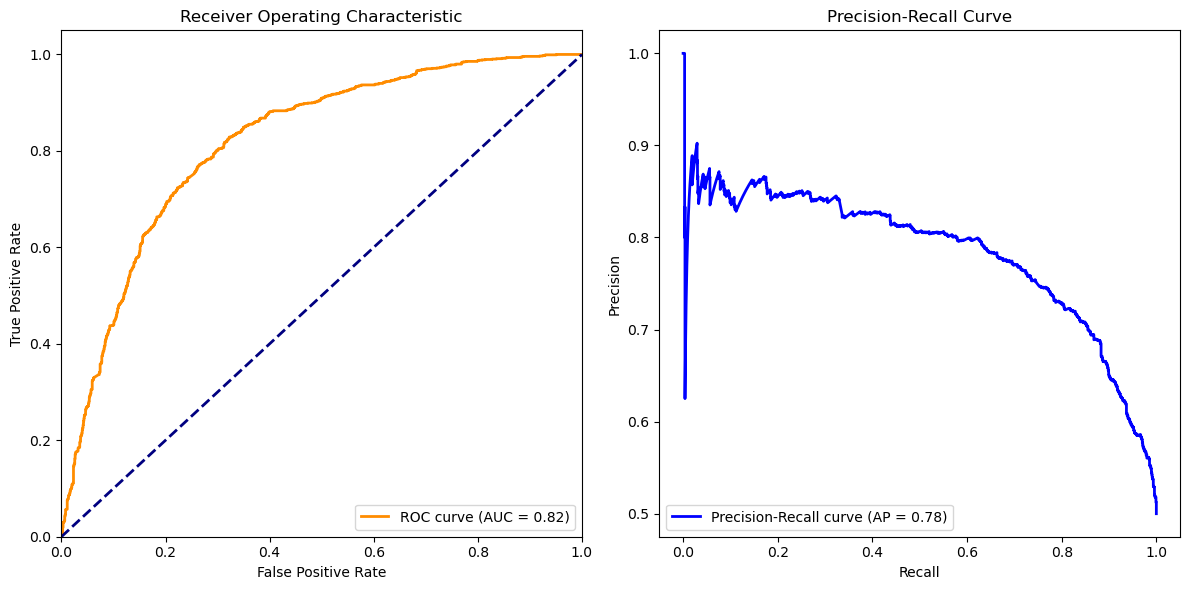

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

#预测概率（SVM需要用`decision_function`或`predict_proba`）
#对于SVC，使用decision_function获取决策函数的输出
test_probabilities = best_svm_model.predict_proba(test_features)[:, 1]

#计算ROC数据
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)
roc_auc = auc(fpr, tpr)

#计算Precision-Recall曲线
precision, recall, _ = precision_recall_curve(test_labels, test_probabilities)
average_precision = average_precision_score(test_labels, test_probabilities)

#绘制ROC曲线
plt.figure(figsize=(12, 6))

#ROC曲线
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#Precision-Recall曲线
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()